In [8]:
from darts import TimeSeries
from datetime import datetime

from dateutil.parser import parse
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
from statsmodels.tsa.stattools import adfuller
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf

import os
import torch
import shutil
import warnings
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from darts.metrics import mape
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 15, 5

## 1. 데이터 로드

### 1-1. 데이터 변경 사항

- 날짜 인덱스를 6초 간격으로 변경 (1분 당 10개의 데이터)
- TAG와 상관관계가 낮은 MELT_WEIGHT의 경우 제외
- 무의미한 NUM 제외
- 불량 데이터(TAG가 'NG'인 데이터)는 제외함

### 1-2. 데이터 정보
총 658133 개
결측값은 불량 데이터

In [9]:
df = pd.read_csv('./public/data/raw_data.csv')

df['TAG'] = df['TAG'] == 'NG'

df.index = pd.date_range(start='3/4/2020', end='5/1/2020', freq='6S')[:-1]

df.drop(columns='STD_DT', inplace=True)
df.drop(columns='NUM', inplace=True)
df.drop(columns='MELT_WEIGHT', inplace=True)

abnormal_df = df[df['TAG'] == True].copy(False)
df = df[df['TAG'] == False]

df = df.astype(np.float32)
df['TAG'] = df['TAG'].astype(bool)

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 658133 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   658133 non-null  float32
 1   MOTORSPEED  658133 non-null  float32
 2   INSP        658133 non-null  float32
 3   TAG         658133 non-null  bool   
dtypes: bool(1), float32(3)
memory usage: 13.2 MB


,MELT_TEMP,MOTORSPEED,INSP
count,658133.000000,658133.000000,658133.000000
mean,529.866028,547.574158,3.196524
std,136.054459,693.753418,0.012527
min,311.000000,0.000000,3.170000
25%,443.000000,128.000000,3.190000
50%,479.000000,173.000000,3.190000
75%,714.000000,1701.000000,3.210000
max,832.000000,1804.000000,3.230000


In [10]:
index = (df.index.month == 3)
train_df = df[index]
real_time_df = df[~index]

In [11]:
train_x_df = train_df.copy(False)
train_y_df = pd.DataFrame(train_x_df.pop('TAG'), columns=['TAG'])

real_time_x_df = real_time_df.copy(False)
real_time_y_df = pd.DataFrame(real_time_x_df.pop('TAG'), columns=['TAG'])

train_x_df

,MELT_TEMP,MOTORSPEED,INSP
2020-03-04 00:00:00,489.0,116.0,3.19
2020-03-04 00:00:06,433.0,78.0,3.19
2020-03-04 00:00:12,464.0,154.0,3.19
2020-03-04 00:00:18,379.0,212.0,3.19
2020-03-04 00:00:24,798.0,1736.0,3.21
...,...,...,...
2020-03-31 23:59:00,465.0,117.0,3.20
2020-03-31 23:59:12,533.0,175.0,3.19
2020-03-31 23:59:24,717.0,1739.0,3.22
2020-03-31 23:59:30,755.0,1732.0,3.22


### 1-3. 시계열 데이터로 변환

- 결측값에 대한 해결이 필요함

In [12]:
train_x_series = TimeSeries.from_dataframe(train_x_df, freq='6S', fill_missing_dates=True)
train_y_series = TimeSeries.from_dataframe(train_y_df, freq='6S', fill_missing_dates=True)
real_time_x_series = TimeSeries.from_dataframe(real_time_x_df, freq='6S', fill_missing_dates=True)
real_time_y_series = TimeSeries.from_dataframe(real_time_y_df, freq='6S', fill_missing_dates=True)

train_x_series

<TimeSeries (DataArray) (time: 403200, component: 3, sample: 1)>
array([[[489.  ],
        [116.  ],
        [  3.19]],

       [[433.  ],
        [ 78.  ],
        [  3.19]],

       [[464.  ],
        [154.  ],
        [  3.19]],

       ...,

       [[   nan],
        [   nan],
        [   nan]],

       [[   nan],
        [   nan],
        [   nan]],

       [[514.  ],
        [141.  ],
        [  3.2 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-03-04 ... 2020-03-31T23:59:54
  * component  (component) object 'MELT_TEMP' 'MOTORSPEED' 'INSP'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### 1-4. Scaling

In [13]:
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, robust_scale

scaler = Scaler(scaler=MinMaxScaler())

train_scaled = scaler.fit_transform(train_x_series)
real_time_scaled = scaler.transform(real_time_x_series)

train_scaled = train_scaled.astype(np.float32)
real_time_scaled = real_time_scaled.astype(np.float32)

train_scaled.pd_dataframe().info()
real_time_scaled.pd_dataframe().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 403200 entries, 2020-03-04 00:00:00 to 2020-03-31 23:59:54
Freq: 6S
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   288279 non-null  float32
 1   MOTORSPEED  288279 non-null  float32
 2   INSP        288279 non-null  float32
dtypes: float32(3)
memory usage: 7.7 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 432000 entries, 2020-04-01 00:00:00 to 2020-04-30 23:59:54
Freq: 6S
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   MELT_TEMP   369854 non-null  float32
 1   MOTORSPEED  369854 non-null  float32
 2   INSP        369854 non-null  float32
dtypes: float32(3)
memory usage: 8.2 MB


## 2. 모델 최초 학습

### 2-1. 결측치 제외

In [14]:
from darts.utils.missing_values import extract_subseries

# 윈도우 크기 : 6분
window_size = 30

train_scaled_list = extract_subseries(train_scaled)

train_scaled_list = [x for x in train_scaled_list if len(x) > 50]

train_scaled_list

[<TimeSeries (DataArray) (time: 188733, component: 3, sample: 1)>
 array([[[0.3365571 ],
         [0.06455203],
         [0.33333588]],
 
        [[0.22823983],
         [0.04340568],
         [0.33333588]],
 
        [[0.28820115],
         [0.08569839],
         [0.33333588]],
 
        ...,
 
        [[0.3597679 ],
         [0.07122983],
         [0.33333588]],
 
        [[0.18955517],
         [0.04284919],
         [0.33333588]],
 
        [[0.28820115],
         [0.0951586 ],
         [0.33333588]]], dtype=float32)
 Coordinates:
   * time       (time) datetime64[ns] 2020-03-04 ... 2020-03-17T02:33:12
   * component  (component) object 'MELT_TEMP' 'MOTORSPEED' 'INSP'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (time: 89, component: 3, sample: 1)>
 array([[[0.8181818 ],
         [0.95937675],
         [0.66666794]],
 
        [[0.81624764],
         [0.9705064 ],
         [0.66666794]],
 

In [17]:
from darts.models import TransformerModel, RNNModel, TCNModel, NBEATSModel
from darts.utils.likelihood_models import LaplaceLikelihood
model_name = 'NBEATSModel'
epoch = 10

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.01,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [my_stopper]}

model = NBEATSModel(
    input_chunk_length=window_size,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=epoch,
    nr_epochs_val_period=1,
    batch_size=epoch,
    model_name=model_name,
    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [4],
        "callbacks": [my_stopper]
    }
)

In [18]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [19]:
createFolder('./models/'+ model_name +'/')
for i, x in enumerate(train_scaled_list):
    if i > 0:
        print(len(x))
        model = model.load(f'./models/{model_name}/{model_name}.pt')
    model.fit(series=x, verbose=True, epochs=epoch*(i+1))
    model.save(f'./models/{model_name}/{model_name}.pt')

2022-11-04 04:38:19 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-04 04:38:19 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 04:38:19 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 04:38:19 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 04:38:20 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
2022-11-04 04:38:20 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total

Epoch 5: 100%|██████| 18871/18871 [12:02<00:00, 26.13it/s, loss=0.00258, train_loss=0.00353]
89


2022-11-04 05:50:30 pytorch_lightning.utilities.rank_zero INFO: Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
2022-11-04 05:50:31 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-04 05:50:31 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 05:50:31 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 05:50:31 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 05:50:31 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
2022-11-04 05:50:31 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | Me

Epoch 0: 100%|██████████████| 6/6 [00:00<00:00, 25.33it/s, loss=0.00214, train_loss=0.00125]
69


2022-11-04 05:50:32 pytorch_lightning.utilities.rank_zero INFO: Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
2022-11-04 05:50:32 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-04 05:50:32 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 05:50:32 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 05:50:32 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 05:50:32 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
2022-11-04 05:50:32 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | Me

Epoch 0: 100%|██████████████| 4/4 [00:00<00:00, 25.14it/s, loss=0.00296, train_loss=0.00459]
72


2022-11-04 05:50:34 pytorch_lightning.utilities.rank_zero INFO: Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
2022-11-04 05:50:34 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (cuda), used: True
2022-11-04 05:50:34 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-11-04 05:50:34 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-11-04 05:50:34 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-11-04 05:50:34 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
2022-11-04 05:50:34 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | Me

Epoch 0: 100%|██████████████| 5/5 [00:00<00:00, 27.51it/s, loss=0.00341, train_loss=0.00428]


In [23]:
pred_len = 1000
prediction = model.predict(n=pred_len)

prediction

2022-11-04 06:01:07 pytorch_lightning.accelerators.cuda INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]


Predicting DataLoader 0: 100%|████████████████████████████████| 1/1 [00:02<00:00,  2.18s/it]


<TimeSeries (DataArray) (time: 1000, component: 3, sample: 1)>
array([[[0.15934074],
        [0.12029454],
        [0.258421  ]],

       [[0.31879333],
        [0.09949747],
        [0.3667536 ]],

       [[0.25078157],
        [0.04301468],
        [0.33123294]],

       ...,

       [[0.15934074],
        [0.12029454],
        [0.258421  ]],

       [[0.8400315 ],
        [0.9538758 ],
        [0.75639695]],

       [[0.8400315 ],
        [0.9538758 ],
        [0.75639695]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2020-03-17T02:59:36 ... 2020-03-17T04:39:30
  * component  (component) object 'MELT_TEMP' 'MOTORSPEED' 'INSP'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

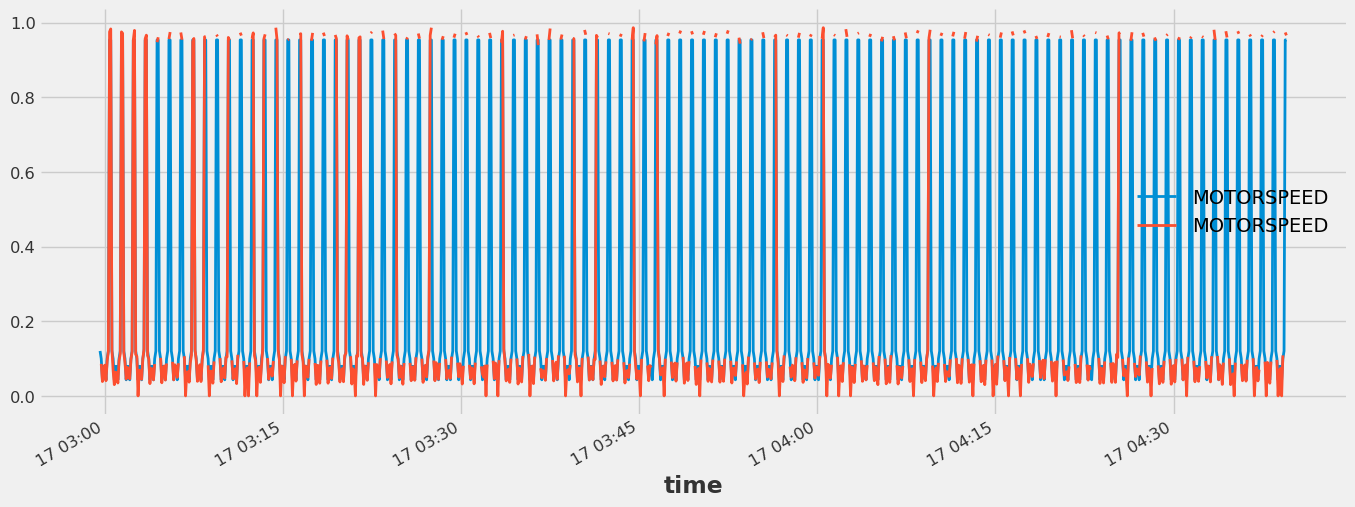

In [26]:
prediction['MOTORSPEED'].plot()
b = train_scaled.split_after(pd.Timestamp('2020-03-17 02:59:36'))[1]
(b['MOTORSPEED'])[:pred_len].plot()
# real_time_x_series['MOTORSPEED'].plot()

In [27]:
from darts.metrics import mae
mae(prediction['MOTORSPEED'], (b['MOTORSPEED'])[:pred_len])

0.010455605